* Παναγιώτης Ζευγολατάκος 03117804
* Χατζηθεοδώρου Ιάσων 03117089
* Ανδρέας Βεζάκης 03117186

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Severity of Road Traffic Injuries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from copy import deepcopy
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_validate,learning_curve
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

### Διάβασμα δεδομένων

In [ ]:
characteristics = pd.read_csv('/content/drive/My Drive/NTUA/Semester9/NeuralNetworks/caracteristiques-2019.csv')
characteristics.name = 'characteristics'
places = pd.read_csv('/content/drive/My Drive/NTUA/Semester9/NeuralNetworks/lieux-2019.csv')
places.name = 'places'
drivers = pd.read_csv('/content/drive/My Drive/NTUA/Semester9/NeuralNetworks/usagers-2019.csv')
drivers.name = 'drivers'
vehicles = pd.read_csv('/content/drive/My Drive/NTUA/Semester9/NeuralNetworks/vehicules-2019.csv')
vehicles.name = 'vehicles'

characteristics = characteristics.set_index('Num_Acc')
places = places.set_index('Num_Acc')
vehicles = vehicles.set_index('id_vehicule')
drivers = drivers.set_index('id_vehicule')

### Παρουσίαση Dataset

Το συγκεκριμένο dataset περιέχει δεδομένα από αυτοκινητιστικά ατυχήματα που έγιναν το 2019 στη Γαλλία. Το κάθε ατύχημα περιέχει τουλάχιστον ένα θύμα, ένα αυτοκίνητο και συμβαίνει σε δημόσιο ή ιδιωτικό δρόμο. Τα δεδομένα είναι διαθέσιμα στον σύνδεσμο [Kaggle - 2019 database of road traffic injuries](https://www.kaggle.com/dorianvoydie/2019-database-of-road-traffic-injuries)

Τα labels που δίνονται για κάθε ατύχημα περιγράφουν τη σοβαρότητα του ατυχήματος και πιο συγκεκριμένα την κατάσταση του θύματος:
1. Χωρίς σωματικές βλάβες
2. Απεβίωσε 
3. Νοσηλεία σε νοσοκομείο λόγω τραυματισμού
4. Ελαφρύς τραυματισμός

Το dataset χωρίζεται σε 4 μέρη: 
1. characteristics - 58840 δείγματα
2. places - 58840 δείγματα
3. vehicles - 132977 δείγματα
4. drivers - 100710 δείγματα

Κάθε ένα από αυτά περιέχει τις αντίστοιχες πληροφορίες για τα ατυχήματα. Ο λόγος που προκύπτουν διαφορετικά είναι πως σε ένα ατύχημα εμπλέκονται πιθανώς πολλοί οδηγοί και άρα πολλά οχήματα. Σε κάθε περίπτωση το dataset έχει δώσει μοναδικό ID σε κάθε ατύχημα ώστε να μπορούν να συσχετιστούν αυτά τα δεδομένα μεταξύ τους. 

Τα labels βρίσκονται στη στήλη `drivers.grav`.

Παρατηρούμε επίσης ότι υπάρχει στήλη για το έτος που έγινε το ατύχημα, `characteristics.an`, η οποία είναι περιττή εφόσον όλα τα δεδομένα μας συλλέχθηκαν στη διάρκεια του έτους 2019.

#### Μη συμπληρωμένα χαρακτηριστικά

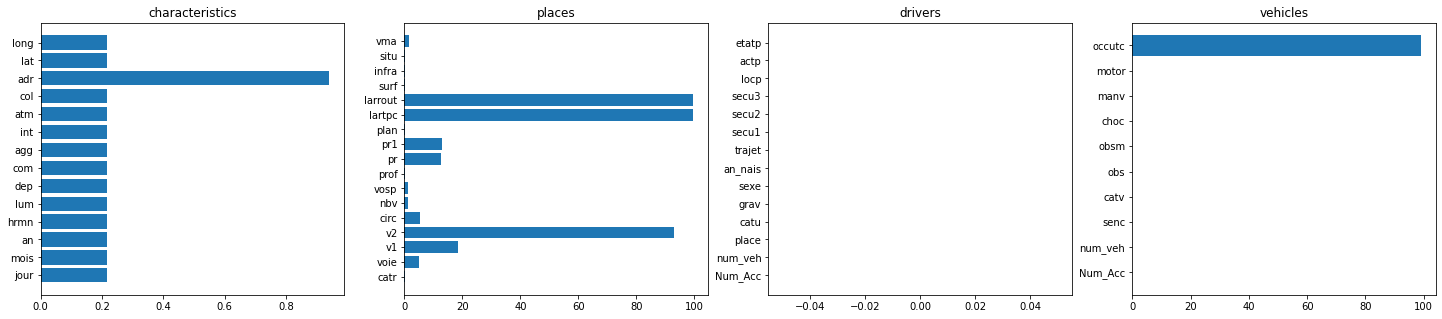

In [ ]:
data = [characteristics, places, drivers, vehicles]

# NaN occurences in vehicles.occutc
def count_nan(df, col):
    return df[col].isnull().sum()

def calculate_nan_per_column(df):
    keys = []
    values = []
    for k in df.keys():
        keys.append(k)
        values.append(count_nan(df, k) / df.shape[0] * 100)
    return keys, values

titles = ['characteristics', 'places', 'drivers', 'vehicles']

features = []
nans = []
for d in data:
    f, n = calculate_nan_per_column(d)
    features.append(f)
    nans.append(n)

size_x = 25
size_y = 5
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(size_x, size_y))
idx = 0
for row in ax:
    row.barh(features[idx], nans[idx])
    row.title.set_text(titles[idx])
    idx += 1

plt.show()

Όπως φαίνεται τα χαρακτηριστικά larrout, lartpc, v2 και occutc λείπουν σε πάνω από το 80 % των δειγμάτων και άρα είναι καλή ιδέα να τα αφαιρέσουμε.

#### Πλήθος δειγμάτων ανά κατηγορία

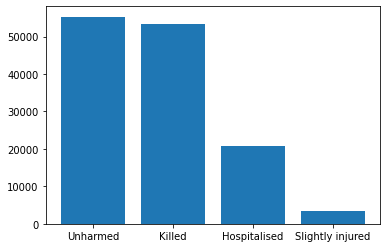

In [ ]:
labels = drivers['grav'].value_counts()
plt.bar(['Unharmed', 'Killed', 'Hospitalised', 'Slightly injured'], labels)
plt.show()

Όπως φαίνεται, το dataset δεν είναι ισορροπημένο καθώς ο αριθμός των θυμάτων που χρειάστηκαν νοσηλεία και των θυμάτων με ελαφρά τραύματα είναι πολύ χαμηλός. Αυτό μάλλον θα μας οδηγήσει να πολλαπλασιάσουμε τα δείγματα αυτών των κατηγοριών.

#### Κατανομή τιμών για κάθε χαρακτηριστικό

Παρακάτω κάνουμε plot τα ιστογράμματα των χαρακτηριστικών κάθε αρχείου

In [ ]:
def plot_value_frequencies(df, cols=4, figsize=(5, 3.5)):
    selected = df.select_dtypes(include=['float64','int64'])
    key_list = selected.keys()
    nkeys = len(key_list)
    columns = cols
    rows = nkeys // columns + 1
    
    figsize = (figsize[0] * columns, figsize[1] * rows)
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    ax_list = axs.ravel()
    for ax in ax_list:
        ax.set_axis_off()

    for i, k in enumerate(key_list):
        ax = ax_list[i]
        ax.set_axis_on()
        sns.histplot(df[k], label=k, ax=ax, kde=True, stat="density", linewidth=0)
        #df[k].value_counts().hist(ax=ax, bins=20)
        #ax.set_title(k)
    
    plt.show()

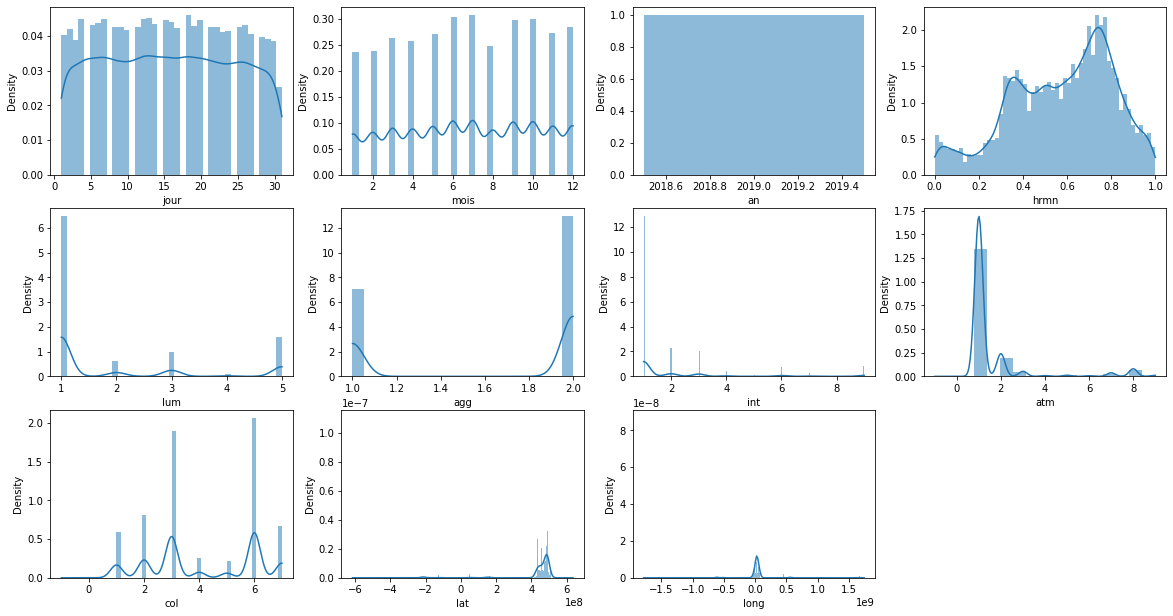

In [ ]:
plot_value_frequencies(characteristics)

Όπως ήταν αναμενόμενο το `characteristics.an` αποτελείται από μόνο μια μπάρα.

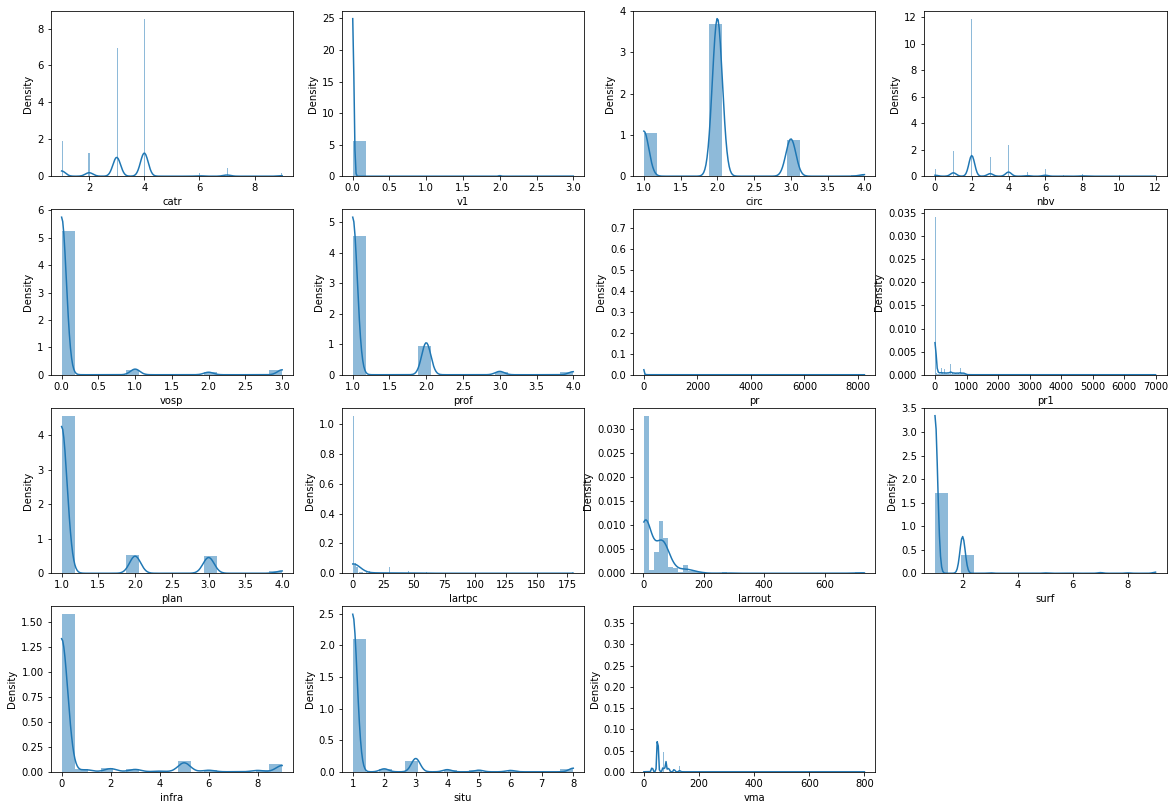

In [ ]:
plot_value_frequencies(places)

Τα χαρακτηριστικά `places.v1`, `places.vosp`, `places.infra`, `places.situ` μαζεύουν την κατανομή στις αρχικές τιμές πολύ έντονα. 

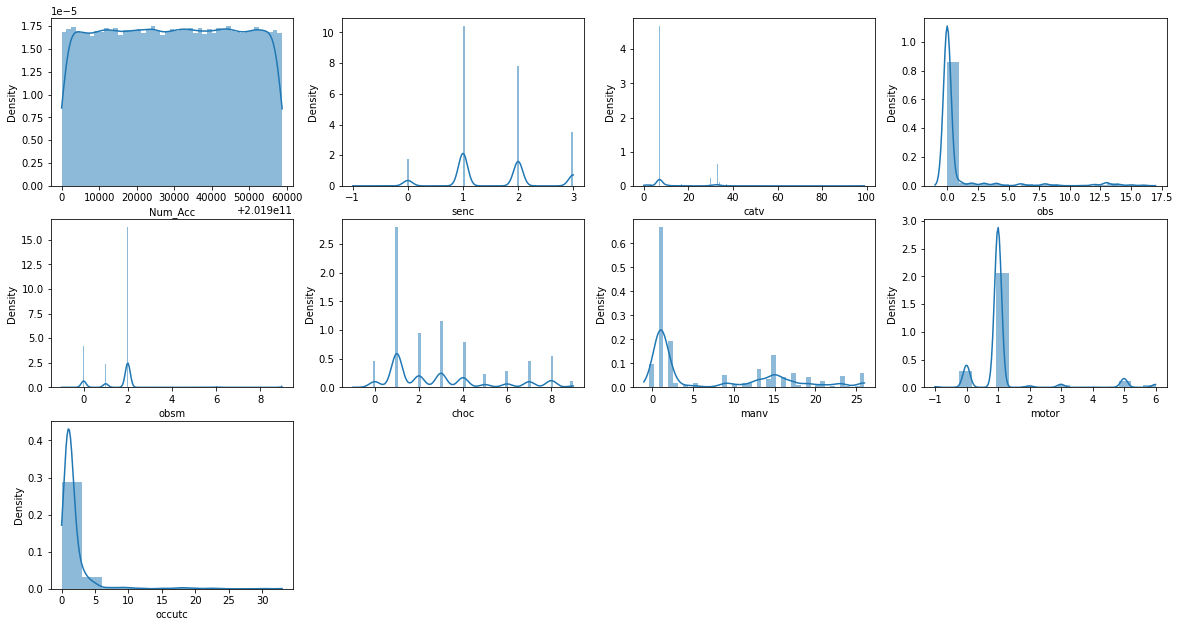

In [ ]:
plot_value_frequencies(vehicles, cols=4)

Το χαρακτηριστικό `vehicles.obs` μαζεύει τη συντριπτική πλειοψηφία των τιμών στο 0.

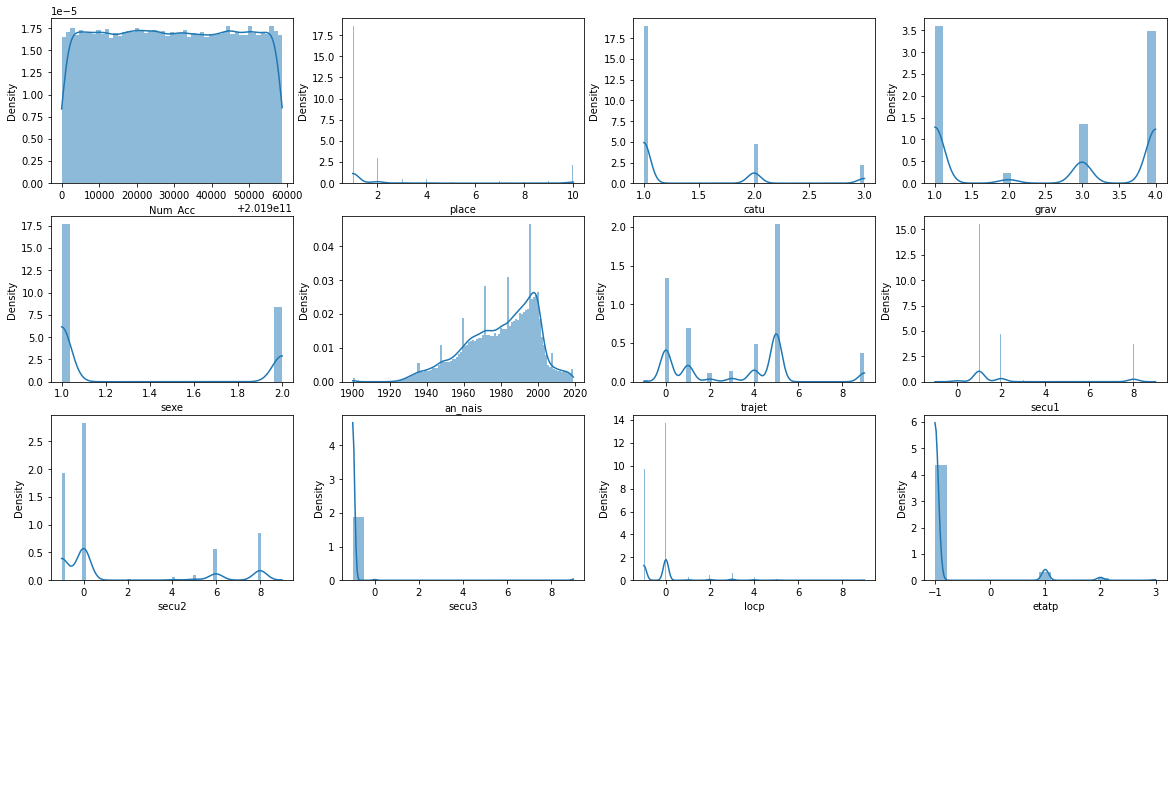

In [ ]:
plot_value_frequencies(drivers)

Το χαρακτηριστικό `drivers.secu3` είναι σχεδόν σταθερό για όλα τα δεδομένα.

### Προετοιμασία

Παρακάτω αφαιρούμε τις στήλες που είναι άχρηστες βάσει της ανάλυσης που προηγήθηκε

In [ ]:
characteristics = characteristics.drop(['an'], axis=1)
places = places.drop(['larrout', 'lartpc', 'v2', 'v1', 'vosp'], axis=1)
vehicles = vehicles.drop(['occutc', 'obs'], axis=1)
driers = drivers.drop(['secu3'], axis=1)

Έπειτα συνδυάζουμε τα δεδομένα, αρχικά σε δύο ομάδες σχετικές με χαρακτηριστικά και οχήματα αντίστοιχα και αφαιρούμε τις διπλασιασμένες στήλες

In [ ]:
acc_info = pd.concat([characteristics, places.reindex(characteristics.index)], axis=1)
acc_info = acc_info.loc[:,~acc_info.columns.duplicated()] 
#print(acc_info.shape)

veh_info = pd.concat([drivers, vehicles.reindex(drivers.index)], axis=1)
veh_info = veh_info.loc[:,~veh_info.columns.duplicated()]
veh_info.reset_index(drop=True, inplace=True)
veh_info.index = veh_info['Num_Acc'].astype('str')
veh_info = veh_info.drop(['Num_Acc'],axis=1)
#print(veh_info.shape)

df = pd.concat([veh_info, acc_info.reindex(veh_info.index)], axis=1)
df.shape

(132977, 44)

Παρατηρούμε ότι το dataframe που προκύπτει έχει 132977 δείγματα και 44 features.

#### Preprocessing

Σε αυτό το μέρος θα μετατρέψουμε τα κατηγορικά δεδομένα σε αριθμητικά χρησιμοποιώντας το `LabelEncoder` και θα προσπαθήσουμε να συμπληρώσουμε τις τιμές που λείπουν χρησιμοποιώντας την συνάρτηση `DataFrame.fillna`.

In [ ]:
df_preprocessed = df.copy()

label_encoder = LabelEncoder()
for col in df.select_dtypes('object'):
    df_preprocessed[col] = df[col].astype(str)
    df_preprocessed[col] = label_encoder.fit_transform(df_preprocessed[col])

df_preprocessed = df_preprocessed.fillna(df_preprocessed.mean())


In [ ]:
df_preprocessed.shape

(132977, 44)

### Μετρικές 

Θα χρησιμοποιηθούν οι παρακάτω μετρικές για την αξιολόγηση της επίδοσης των μοντέλων
- *Accuracy*
- *Precision*
- *Recall*
- *F1 Score*

Θα χρησιμοποιηθεί επίσης η συνάρτηση `sklearn.metrics.classification_report` για τη συγκεντρωτική εμφάνιση των αποτελεσμάτων.

In [ ]:
scoring_strategies = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

### Χωρισμός των δεδομένων

Θα χωρίσουμε τα δεδομένα σε training και test sets με ποσοστά 75-25.

In [ ]:
#X = np.array(df_preprocessed.drop(['grav'], axis=1))
#y = np.array(df_preprocessed.loc[:,'grav'])

df_train, df_test = train_test_split(df_preprocessed, test_size=0.25, shuffle=True, stratify=df_preprocessed['grav'])

X_train = df_train.drop('grav',axis=1)
y_train = df_train['grav']
X_test = df_test.drop('grav',axis=1)
y_test = df_test['grav']

Θα χρησιμοποιήσουμε 5-fold cross validation, υλοποιημένο από την `cross_val_score` στο sklearn.

### Out-of-the-box Classifiers

In [ ]:
dummy_clf = DummyClassifier()
mlp_clf = MLPClassifier()
svm_clf = LinearSVC(max_iter=40)

In [ ]:
cross_validate(dummy_clf, X_train, y_train, cv=5, scoring=scoring_strategies)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

{'fit_time': array([0.02605057, 0.02478027, 0.02436209, 0.02546382, 0.03057146]),
 'score_time': array([0.02842712, 0.03101993, 0.02566028, 0.02645779, 0.03742933]),
 'test_accuracy': array([0.41595227, 0.41595227, 0.41597313, 0.41597313, 0.41597313]),
 'test_f1_macro': array([0.14688075, 0.14688075, 0.14688595, 0.14688595, 0.14688595]),
 'test_precision_macro': array([0.10398807, 0.10398807, 0.10399328, 0.10399328, 0.10399328]),
 'test_recall_macro': array([0.25, 0.25, 0.25, 0.25, 0.25])}

In [ ]:
@ignore_warnings(category=Warning)
def out_of_the_box_evaluation(X, y):

    names = ['Dummy', 'MLP', 'SVM']

    scores = [  cross_validate(dummy_clf, X, y, cv=5, scoring=scoring_strategies),
                cross_validate(mlp_clf, X, y, cv=5, scoring=scoring_strategies),
                cross_validate(svm_clf, X, y, cv=5, scoring=scoring_strategies)    ]

    return names, scores


In [ ]:
names, scores = out_of_the_box_evaluation(X_train, y_train)

In [ ]:
def plot_scores_of_models(scores, names):
    reduced_scores = deepcopy(scores)
    for s in reduced_scores:
      s.pop('fit_time', None)
      s.pop('score_time', None)

    # Calculate mean of scores of the different folds
    avg_scores = []
    for s in reduced_scores:
        avg_scores_of_model = []
        for key in s:
            avg = s[key].mean()
            avg_scores_of_model.append(avg)
        avg_scores.append(avg_scores_of_model)

    # plot
    x = np.arange(len(avg_scores[0])) 
    width = 0.35
    window = width/len(avg_scores)
    fig, ax = plt.subplots(figsize=(10, 5))
    for i, s in enumerate(avg_scores):
        ax.bar(x + (i - len(avg_scores)/2) * window, s, window, label=names[i])
    
    ax.set_ylabel('Metrics')
    ax.set_title('Scores of different models')
    ax.set_xticks(x)
    ax.set_xticklabels(scores[0].keys())
    ax.legend()

    fig.tight_layout()

    plt.show()


Παρακάτω φαίνονται οι επιδόσεις των out of the box ταξινομητών σε γραφική παράσταση και πίνακα.

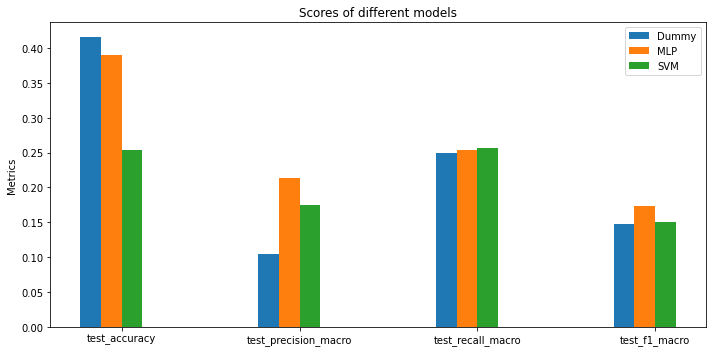

In [ ]:
plot_scores_of_models(scores, names)

In [ ]:
for name, score in zip(names, scores):
  print(name)
  for key in score.keys():
    avg = score[key].mean()
    print(f"{key}: {avg:.5f}")
  print("")

Dummy
test_accuracy: 0.41596
test_precision_macro: 0.10399
test_recall_macro: 0.25000
test_f1_macro: 0.14688

MLP
test_accuracy: 0.38958
test_precision_macro: 0.21361
test_recall_macro: 0.25399
test_f1_macro: 0.17378

SVM
test_accuracy: 0.25389
test_precision_macro: 0.17475
test_recall_macro: 0.25689
test_f1_macro: 0.14984



| Classifier | Fit time | Score time | Accuracy | Precision macro | Recal macro | F1 macro |
|------------|----------|------------|----------|-----------------|-------------|----------|
| Dummy      |      0.01097    |   0.01953         |   0.41596       |   0.10399              |    0.25         |    0.14688      |
| MLP        |     17.106     |   0.06408         |     0.38958     |    0.21361             |     0.25399        |     0.17378     |
| SVM        |   6.506       |    0.03865        |   0.25389      |    0.17475             |        0.25689     |     0.14984     |

Χρησιμοποιώντας out of the box classifiers και χωρίς να επεξεργαστούμε επιπλέον τα δεδομένα, παίρνουμε αρκετά άσχημα αποτελέσματα όπως ήταν αναμενόμενο. Αυτό θα το αντιμετωπίσουμε με κατάλληλο sampling και PCA. Επίσης θα κάνουμε optimize τα hyperparameters των classifiers.

### Sampling

In [ ]:
df_train['grav'].value_counts()

1    41485
4    39980
3    15643
2     2624
Name: grav, dtype: int64

In [ ]:
# Divide by class
df_class_1 = df_train[df_train['grav'] == 1]
df_class_2 = df_train[df_train['grav'] == 2]
df_class_3 = df_train[df_train['grav'] == 3]
df_class_4 = df_train[df_train['grav'] == 4]

In [ ]:
X_test= df_test.drop('grav',axis=1)
y_test = df_test['grav']

#### Oversampling

In [ ]:
chosen_size = 40000
df_class_1_over = df_class_1.sample(chosen_size)
df_class_2_over = df_class_2.sample(chosen_size, replace=True)
df_class_3_over = df_class_3.sample(chosen_size, replace=True)
df_class_4_over = df_class_4.sample(chosen_size, replace=True)
df_train_over = pd.concat([df_class_1_over, df_class_2_over, df_class_3_over, df_class_4_over], axis=0)

In [ ]:
X_train_over = df_train_over.drop('grav',axis=1)
y_train_over = df_train_over['grav']

[]

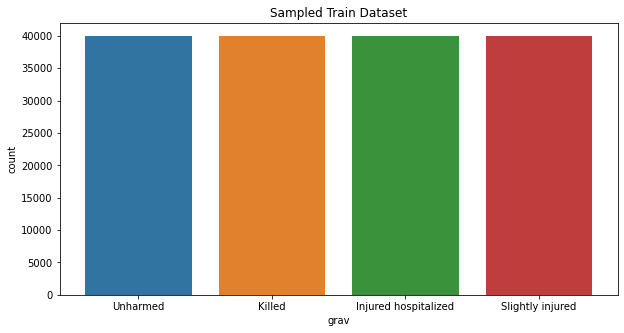

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(10,5),sharey=True)
sns.countplot(ax=axes,x=df_train_over['grav'].map({1:'Unharmed',
                                  2:'Killed',
                                  3:'Injured hospitalized',
                                  4:'Slightly injured'
                                }))
axes.set_title('Sampled Train Dataset')
plt.plot()

#### Undersampling

In [ ]:
chosen_size = 5000
df_class_1_under = df_class_1.sample(chosen_size)
df_class_2_under = df_class_2.sample(chosen_size, replace=True)
df_class_3_under = df_class_3.sample(chosen_size)
df_class_4_under = df_class_4.sample(chosen_size)
df_train_under = pd.concat([df_class_1_under, df_class_2_under, df_class_3_under, df_class_4_under], axis=0)

In [ ]:
X_train = df_train_under.drop('grav',axis=1)
y_train = df_train_under['grav']

[]

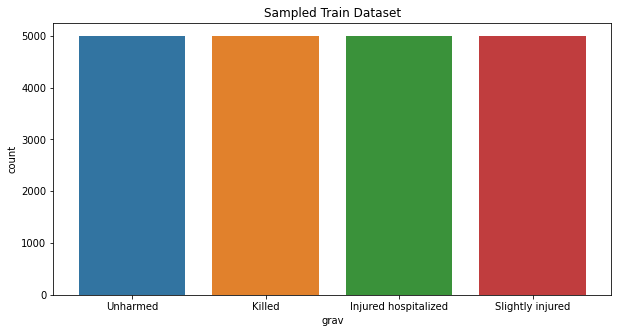

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(10,5),sharey=True)
sns.countplot(ax=axes,x=df_train_under['grav'].map({1:'Unharmed',
                                  2:'Killed',
                                  3:'Injured hospitalized',
                                  4:'Slightly injured'
                                }))
axes.set_title('Sampled Train Dataset')
plt.plot()

### Pipelines

In [ ]:
preprocessor = make_pipeline(StandardScaler()) 
pca_preprocessor = make_pipeline(preprocessor, PCA(n_components=3))
DummyPipeline = make_pipeline(preprocessor,DummyClassifier())
MLPPipeline = make_pipeline(preprocessor,MLPClassifier())
SVMPipeline = make_pipeline(preprocessor,SVC())
SVCLinearPipeline = make_pipeline(preprocessor,LinearSVC())

In [ ]:
dict_of_models = {'Dummy': DummyPipeline,
                  'MLP': MLPPipeline,
                  'SVM': SVMPipeline }

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def evaluation(model, refit=True):
    if refit:
      model.fit(X_train, y_train)
    
    # calculate the predictions
    y_pred = model.predict(X_test)
    print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('-')
    print(confusion_matrix(y_test,y_pred))
    print('-')
    print(classification_report(y_test,y_pred))
    print('-')

@ignore_warnings(category=ConvergenceWarning)
def evaluation_over(model, refit=True):
    if refit:
      model.fit(X_train_over, y_train_over)
    
    # calculate the predictions
    y_pred = model.predict(X_test)
    print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('-')
    print(confusion_matrix(y_test,y_pred))
    print('-')
    print(classification_report(y_test,y_pred))
    print('-')

### MLP Hyperparameter Optimization 

In [ ]:
param_grid_MLP = {
    'mlpclassifier__hidden_layer_sizes': [(100), (400), (100, 100), (300, 300), (400, 200)]
}
MLP_grid = HalvingGridSearchCV(MLPPipeline, param_grid_MLP, scoring='accuracy', n_jobs=-1)
MLP_grid.fit(X_train,y_train)

print(MLP_grid.best_params_)
evaluation(MLP_grid, refit=False)

{'mlpclassifier__max_iter': 200, 'mlpclassifier__hidden_layer_sizes': (100, 100)}
Accuracy =  0.5915476011430291
-
[[10531   266  1286  1746]
 [   73   181   502   118]
 [  666   466  2984  1099]
 [ 3463   369  3525  5970]]
-
              precision    recall  f1-score   support

           1       0.71      0.76      0.74     13829
           2       0.14      0.21      0.17       874
           3       0.36      0.57      0.44      5215
           4       0.67      0.45      0.54     13327

    accuracy                           0.59     33245
   macro avg       0.47      0.50      0.47     33245
weighted avg       0.63      0.59      0.60     33245

-


In [ ]:
param_grid_MLP = {
    'mlpclassifier__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'mlpclassifier__batch_size': [16, 32, 64],
    'mlpclassifier__hidden_layer_sizes': [(100, 100, 100), (200, 100)],
}
MLP_grid = HalvingGridSearchCV(MLPPipeline, param_grid_MLP, scoring='accuracy', n_jobs=-1, refit=True)
MLP_grid.fit(X_train,y_train)

print(MLP_grid.best_params_)
evaluation(MLP_grid, refit=False)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


{'mlpclassifier__batch_size': 16, 'mlpclassifier__hidden_layer_sizes': (200, 100), 'mlpclassifier__learning_rate_init': 0.0001}
Accuracy =  0.5103925402316137
-
[[8442  646 1509 3232]
 [ 111  307  330  126]
 [ 625  983 2208 1399]
 [3117  985 3214 6011]]
-
              precision    recall  f1-score   support

           1       0.69      0.61      0.65     13829
           2       0.11      0.35      0.16       874
           3       0.30      0.42      0.35      5215
           4       0.56      0.45      0.50     13327

    accuracy                           0.51     33245
   macro avg       0.41      0.46      0.42     33245
weighted avg       0.56      0.51      0.53     33245

-


### SVM Hyperparameter Optimization

In [ ]:
param_grid_SVM = {
    'svc__C': [0.1, 1, 10, 100, 1000],
    'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'svc__kernel': ['rbf'],
    'svc__max_iter': [10, 20, 40]
}

SVM_grid = HalvingGridSearchCV(SVMPipeline, param_grid_SVM, scoring='accuracy', n_jobs=-1, refit=True)
SVM_grid.fit(X_train,y_train)

print(SVM_grid.best_params_)
evaluation(SVM_grid, refit=False)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=40).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


{'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__max_iter': 40}
Accuracy =  0.3396300195518123
-
[[9790 2689  560  790]
 [ 524  271   68   11]
 [3217 1438  384  176]
 [8832 3105  544  846]]
-
              precision    recall  f1-score   support

           1       0.44      0.71      0.54     13829
           2       0.04      0.31      0.06       874
           3       0.25      0.07      0.11      5215
           4       0.46      0.06      0.11     13327

    accuracy                           0.34     33245
   macro avg       0.30      0.29      0.21     33245
weighted avg       0.41      0.34      0.29     33245

-


In [ ]:
SVCLinearPipeline.fit(X_train, y_train)

evaluation(SVCLinearPipeline, refit=False)

Accuracy =  0.4903594525492555
-
[[9210 2055  508 2056]
 [ 119  561  101   93]
 [ 962 2246  814 1193]
 [4367 2130 1113 5717]]
-
              precision    recall  f1-score   support

           1       0.63      0.67      0.65     13829
           2       0.08      0.64      0.14       874
           3       0.32      0.16      0.21      5215
           4       0.63      0.43      0.51     13327

    accuracy                           0.49     33245
   macro avg       0.42      0.47      0.38     33245
weighted avg       0.57      0.49      0.51     33245

-


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### PCA Pipeline

Θα χρησιμοποιήσουμε τους καταχωρητές προσθέτοντας και PCA στο pipeline. Λόγω του ότι θα χαθεί πολλή πληροφορία από τη μείωση της διάστασης, θα χρησιμοποιήσουμε τα over sampled δεδομένα.

In [ ]:
MLPPipeline_PCA = make_pipeline(pca_preprocessor, MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=40))
evaluation_over(MLPPipeline_PCA, refit=True)

Accuracy =  0.37359001353587007
-
[[7564 2838 1458 1969]
 [ 132  464  207   71]
 [1174 2168 1210  663]
 [5542 2751 1852 3182]]
-
              precision    recall  f1-score   support

           1       0.52      0.55      0.54     13829
           2       0.06      0.53      0.10       874
           3       0.26      0.23      0.24      5215
           4       0.54      0.24      0.33     13327

    accuracy                           0.37     33245
   macro avg       0.34      0.39      0.30     33245
weighted avg       0.48      0.37      0.40     33245

-


In [ ]:
SVCLinearPipeline_PCA = make_pipeline(pca_preprocessor, LinearSVC())
evaluation_over(SVCLinearPipeline_PCA, refit=True)

Accuracy =  0.3510603098210257
-
[[8773 3447  705  904]
 [ 221  532   61   60]
 [1810 2419  486  500]
 [6949 3456 1042 1880]]
-
              precision    recall  f1-score   support

           1       0.49      0.63      0.56     13829
           2       0.05      0.61      0.10       874
           3       0.21      0.09      0.13      5215
           4       0.56      0.14      0.23     13327

    accuracy                           0.35     33245
   macro avg       0.33      0.37      0.25     33245
weighted avg       0.47      0.35      0.34     33245

-


### Documentation

Ξεκινώντας από τους out-of-the-box ταξινομητές χρειάστηκε να γίνουν κάποιες επεμβάσεις στα δεδομένα έτσι ώστε να βελτιωθεί η απόδοση και φαίνονται παρακάτω

1. Undersampling των μεγάλων κατηγοριών (1, 3, 4)
2. Oversampling της μικρής κατηγορίας (2)
3. Εφαρμογή Standard Scaler ως πρώτο βήμα του pipeline
4. Εφαρμογή PCA ως δεύτερο βήμα του pipeline 
5. Δοκιμή διαφόρων συνδυασμών για hidden layers για το MLP
6. Επιλογή βέλτιστων παραμέτρων για το SVM

Κατά την χρήση των out-of-the-box ταξινομητών παρατηρήσαμε ότι λόγω του unbalanced dataset οι ταξινομητές προέβλεπαν μόνο τις κλάσεις 1 και 4. Τα πρώτα δύο βήματα εφαρμόστηκαν αποκλειστικά στο train dataset με σκοπό να αντιμετωπίσουν αυτό το πρόβλημα. Αρχικά, προσπαθήσαμε να κάνουμε over sampling ώστε όλες οι κλάσεις να έχουν τόσα samples όσα και η μεγαλύτερη, δηλαδή 40000, αλλά αυτό είχε ως αποτέλεσμα να επαναληφθούν πάρα πολλές φορές τα samples της κλάσης 2, που ήταν 2000. Επίσης, σε αυτή την περίπτωση ο χρόνος εκτέλεσης γινόταν απαγορευτικός δεδομένου ότι τρέχαμε το Grid Search στο colab. Αντίστοιχα, όταν κάναμε under sampling σε όλες τις κλάσεις ώστε να έχουν ίσα samples με την 2, αφήναμε αχρησιμοποίητο μεγάλο όγκο δεδομένων. Οπότε, επιλέξαμε να συνδυάσουμε under sampling και over sampling ώστε όλες οι κλάσεις να έχουν 5000 samples.

Για τη δημιουργία των pipelines εφαρμόσαμε αρχικά μόνο Standard Scaler σαν βήμα preprocessing, έτσι ώστε οι τιμές των features να κανονικοποιηθούν και να είναι ευκολότερο το training. Έπειτα δοκιμάσαμε και PCA αλλά χρησιμοποιώντας τα oversampled δεδομένα αυτή τη φορά και μόνο για τους δύο ταξινομητές που είχαν την καλύτερη απόδοση.

Τέλος, χρησιμοποιήσαμε Halving Grid Search για να επιλέξουμε τους βέλτιστους συνδυασμούς υπερπαραμέτρων για κάθε ταξινομητή. Το Halving Grid Search, αντί να δοκιμάσει εξαντλητικά να κάνει cross validate με όλους τους συνδυασμούς σε όλο το train dataset, αυξάνει σταδιακά το μέγεθος του dataset που χρησιμοποιεί και απορρίπτει τους ταξινομητές με την χειρότερη απόδοση στη μετρική που επιλέγεται. Ο λόγος που το επιλέξαμε είναι ότι προσφέρει μεγάλη επιτάχυνση σε σχέση με το απλό Grid Search, μάλιστα σε κάποιες περιπτώσεις είναι μέχρι και 11 φορές γρηγορότερο.

### Results

Παρακάτω θα εμφανίσουμε τα learning curves καθώς και γραφικές παραστάσεις σχετικές με τις μετρικές των δύο ταξινομητών

In [ ]:
chosen_svm = make_pipeline(preprocessor, LinearSVC())
chosen_mlp =  make_pipeline(preprocessor, MLPClassifier(hidden_layer_sizes=(100, 100)))

In [ ]:
N_mlp, train_score_mlp, test_score_mlp = learning_curve(chosen_mlp, X_train, y_train, 
                                           cv=5, scoring='accuracy', 
                                           train_sizes=np.linspace(0.1,1,10))


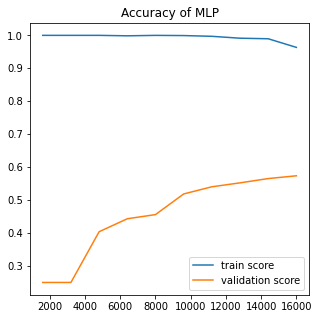

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(N_mlp, train_score_mlp.mean(axis=1), label='train score')
plt.plot(N_mlp, test_score_mlp.mean(axis=1), label='validation score')
plt.legend()
plt.title('Accuracy of MLP')
plt.show()

In [ ]:
N_svc, train_score_svc, test_score_svc = learning_curve(chosen_svm, X_train, y_train, 
                                           cv=5, scoring='accuracy', 
                                           train_sizes=np.linspace(0.1,1,10))

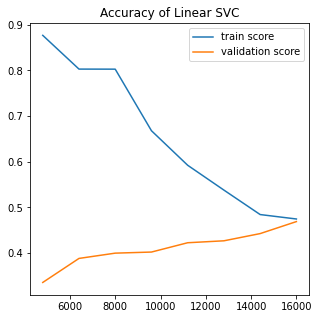

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(N_svc, train_score_svc.mean(axis=1), label='train score')
plt.plot(N_svc, test_score_svc.mean(axis=1), label='validation score')
plt.legend()
plt.title('Accuracy of Linear SVC')
plt.show()

In [ ]:
names = ['MLP(100, 100)', 'Linear SVC']
scores = [  cross_validate(chosen_mlp, X_train, y_train, cv=5, scoring=scoring_strategies),
            cross_validate(chosen_svm, X_train, y_train, cv=5, scoring=scoring_strategies)   ]

#plot_scores_of_models(names, scores)

In [ ]:
scores

[{'score_time': array([0.03393745, 0.03506064, 0.03245902, 0.04106402, 0.03262472]),
  'test_accuracy': array([0.57325, 0.57025, 0.569  , 0.5575 , 0.57725]),
  'test_f1_macro': array([0.56622055, 0.56184889, 0.56378137, 0.55102061, 0.56979417]),
  'test_precision_macro': array([0.56304625, 0.55958055, 0.56214237, 0.54805643, 0.5657406 ]),
  'test_recall_macro': array([0.57325, 0.57025, 0.569  , 0.5575 , 0.57725])},
 {'score_time': array([0.01829481, 0.0174191 , 0.01684475, 0.01641679, 0.0199132 ]),
  'test_accuracy': array([0.4755 , 0.46275, 0.4715 , 0.4695 , 0.46475]),
  'test_f1_macro': array([0.45311708, 0.44400629, 0.44956139, 0.44940185, 0.44414401]),
  'test_precision_macro': array([0.46482008, 0.45070036, 0.45800807, 0.45706689, 0.44901297]),
  'test_recall_macro': array([0.4755 , 0.46275, 0.4715 , 0.4695 , 0.46475])}]

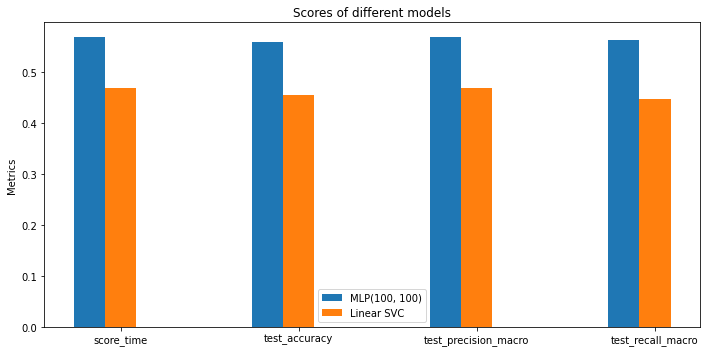

In [ ]:
reduced_scores = deepcopy(scores)
for s in reduced_scores:
  s.pop('fit_time', None)
  s.pop('score_time', None)

# Calculate mean of scores of the different folds
avg_scores = []
for s in reduced_scores:
    avg_scores_of_model = []
    for key in s:
        avg = s[key].mean()
        avg_scores_of_model.append(avg)
    avg_scores.append(avg_scores_of_model)

# plot
x = np.arange(len(avg_scores[0])) 
width = 0.35
window = width/len(avg_scores)
fig, ax = plt.subplots(figsize=(10, 5))
for i, s in enumerate(avg_scores):
    ax.bar(x + (i - len(avg_scores)/2) * window, s, window, label=names[i])
    
ax.set_ylabel('Metrics')
ax.set_title('Scores of different models')
ax.set_xticks(x)
ax.set_xticklabels(scores[0].keys())
ax.legend()

fig.tight_layout()
plt.show()

Δυστυχώς τα παραπάνω αποτελέσματα δεν βελτιώνουν ικανοποιητικά την απόδοση, σε σχέση με την περίπτωση της τυχαίας επιλογής με βάση των κατανομή των δεδομένων στις κλάσεις. Ακόμα και σε περιπτώσεις που χρησιμοποιήθηκαν πολλά hidden layers το νευρωνικό δεν βελτίωνε το accuracy και συνέχιζε να κάνει ιδιαίτερα πολλά λάθη στη δεύτερη κατηγορία, ακόμα και μετά από χρήση PCA.

### Conclusion

Είναι φανερό ότι οι δύο ταξινομητές (LinearSVC, MLP) δεν προσφέρουν ικανοποιητική απόδοση, τουλάχιστον στις επιλογές υπερπαραμέτρων που έγιναν. Ιδιαίτερα για το MLP, είναι πιθανό με μεγάλη αύξηση των hidden layers να διακρίνει καλύτερα τις κατηγορίες, αλλά δεδομένου του χρόνου εκτέλεσης στο scikit, κάτι τέτοιο είναι απαγορευτικό. 

Είναι παρόλα αυτά ενδιαφέρον το γεγονός ότι είτε με over sampling είτε με under sampling, η κατηγορία 2 εμφανίζει πάρα πολλά λάθη στις προβλέψεις, κάτι που φανερώνει και προβλήματα του dataset. 

Από τους δύο ταξινομητές, ο MLP φαίνεται καλύτερος ως προς το accuracy και πιθανώς με μεγαλύτερο tuning των υπερπαραμέτρων να μπορεί να πετύχει καλύτερα αποτελέσματα. Ο Linear SVC αντίθετα έχει πολύ χειρότερο accuracy.